In [ ]:
!pip install -q "monai-weekly[tqdm]"
!python -c "import generative" || pip install -q monai-generative
!python -c "import lpips" || pip install -q lpips
!python -c "import pydicom" || pip install -q pydicom
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
import os
import shutil
import tempfile
import subprocess
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


MONAI version: 1.4.dev2404
Numpy version: 1.24.3
Pytorch version: 2.1.2+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 3ebfa1ee9980ae588ac19164d797684069af4c5a
MONAI __file__: C:\Users\<username>\AppData\Roaming\Python\Python311\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.0
scikit-image version: 0.20.0
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: 2.15.1
gdown version: 4.6.3
TorchVision version: 0.16.2+cpu
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 1.5.3
einops version: 0.7.0
transformers version: 4.37.0
mlflow version: 2.9.2
pynrrd version: 1.0.0
clearml version: 1.14.2rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\BIRGIT~1\AppData\Local\Temp\tmpze24_p8n


In [3]:
!pip install --quiet idc-index
import pydicom
import subprocess
import random
from pydicom.pixel_data_handlers.util import apply_voi_lut
from idc_index import index

In [4]:
# IDC data download script
collection_id = "cmb_lca"  # Replace with the actual collection ID
client = index.IDCClient()
query = f"""
SELECT
  series_aws_url
FROM
  index
WHERE
  Modality = 'MR'
  AND collection_id = '{collection_id}'
"""
result = client.sql_query(query)

In [5]:
# Extract S3 URLs
s3_urls = result.series_aws_url.tolist()



In [6]:
# Randomly select a subset for training and validation
random.seed(42)  # Set a seed for reproducibility
random.shuffle(s3_urls)

train_size = 40
validation_size = 30

In [7]:
train_urls = s3_urls[:train_size]
validation_urls = s3_urls[train_size:train_size + validation_size]

In [8]:
# Download DICOM files for training set
train_download_dir = os.path.join(root_dir, "MR_DICOM", "train")
os.makedirs(train_download_dir, exist_ok=True)

In [9]:
for s3_url in tqdm(train_urls, desc="Downloading DICOM files for training set"):
    result = subprocess.run([client.s5cmdPath, '--no-sign-request', 'cp', s3_url, train_download_dir], stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')

In [10]:
# Download DICOM files for validation set
validation_download_dir = os.path.join(root_dir, "MR_DICOM", "validation")
os.makedirs(validation_download_dir, exist_ok=True)

In [11]:
for s3_url in tqdm(validation_urls, desc="Downloading DICOM files for validation set"):
    result = subprocess.run([client.s5cmdPath, '--no-sign-request', 'cp', s3_url, validation_download_dir], stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')

In [12]:
# Custom DICOM Dataset class
class CustomDICOMDataset:
    def __init__(self, root_dir, spatial_size=(64, 64)):
        self.root_dir = root_dir
        self.class_names = self._find_classes()
        self.spatial_size = spatial_size
        self.data = self._load_dataset()

    def _find_classes(self):
        class_names = [d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))]
        return class_names

    def _load_dataset(self):
        data = []  # List to store file paths and class names
        for class_name in self.class_names:
            class_path = os.path.join(self.root_dir, class_name)
            for file in os.listdir(class_path):
                if file.endswith(".dcm"):
                    file_path = os.path.join(class_path, file)
                    data.append({"image": file_path, "class_name": class_name})
        return data

    def __getitem__(self, index):
        item = self.data[index]
        class_name = item['class_name']
        return {'file_path': item['image'], 'class_name': class_name}

    def __len__(self):
        return len(self.data)

In [13]:
# Create a custom dataset
max_image_size = (64, 64)
train_data = CustomDICOMDataset(os.path.join(root_dir, "MR_DICOM"))

In [14]:
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "train"]

In [15]:
image_size = pydicom.read_file(train_datalist[0]['image']).pixel_array.shape
image_size

(512, 512)

In [17]:
train_transforms = transforms.Compose([
    transforms.LoadImageD(keys=["image"]),  # Use LoadImageD for DICOM files
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.SqueezeDimd(keys=["image"], dim=-1),
    transforms.Resized(keys=["image"], spatial_size=(64, 64), mode="bicubic", align_corners=False),
    transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    transforms.RandAffined(
        keys=["image"],
        rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
        translate_range=[(-1, 1), (-1, 1)],
        scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
        spatial_size=(64, 64),  # Adjusted spatial_size for 2D
        padding_mode="border",
        prob=0.5,
    ),
    transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
    transforms.Resized(keys=["low_res_image"], spatial_size=(16, 16)),
])

# Apply the transformation to the dataset without caching
train_ds = Dataset(data=train_datalist, transform=train_transforms)
sample = train_ds[0]

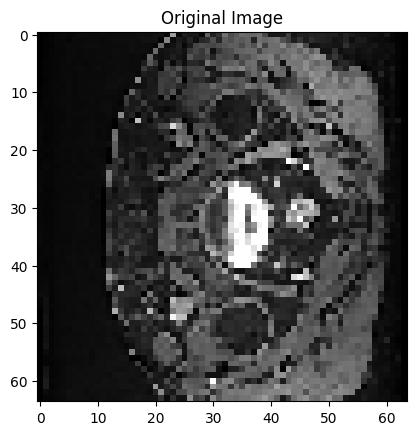

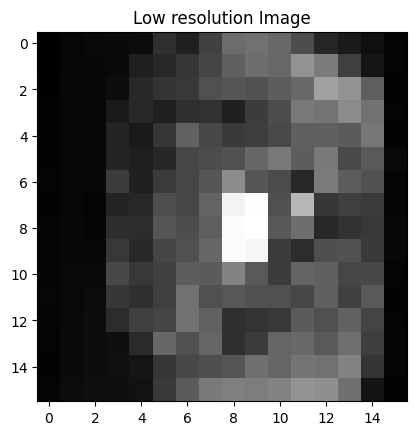

In [18]:
#%% extra check for dataset
sample = train_ds[0]
original_image = sample["image"]
low_res_image = sample["low_res_image"]

plt.imshow(original_image[0, :, :], cmap="gray")
plt.title("Original Image")
plt.show()

plt.imshow(low_res_image[0,:,:], cmap="gray")
plt.title("Low resolution Image")
plt.show()

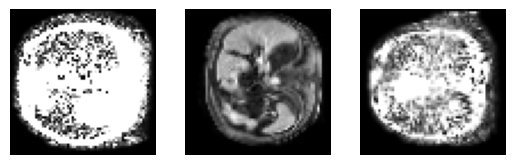

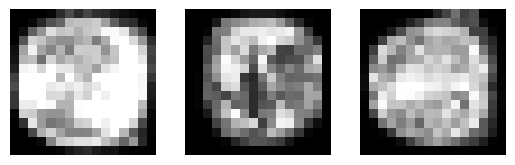

In [19]:
train_loader = DataLoader(train_ds, batch_size=5, shuffle=True, num_workers=0)
# # Apply the transformation to the dataset
# train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
# train_loader = DataLoader(train_ds, batch_size=5, shuffle=True, num_workers=4, persistent_workers=True)
# %%
#Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for i in range(3):
    ax[i].imshow(check_data["image"][i, 0, :, :], cmap="gray")
    ax[i].axis("off")

# %%
# Plot 3 examples from the training set in low resolution
fig, ax = plt.subplots(nrows=1, ncols=3)
for i in range(3):
    ax[i].imshow(check_data["low_res_image"][i, 0, :, :], cmap="gray")
    ax[i].axis("off")

In [20]:
# ## Create data loader for validation set
val_data = CustomDICOMDataset(os.path.join(root_dir, "MR_DICOM"))
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "validation"]

In [21]:
len(val_datalist)

1028

In [22]:
val_transforms = transforms.Compose(
    [
        transforms.LoadImageD(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.SqueezeDimd(keys=["image"], dim=-1),
        transforms.Resized(keys=["image"], spatial_size=(64, 64),mode="bicubic"),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
        transforms.Resized(keys=["low_res_image"], spatial_size=(16,16)),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=5, shuffle=True, num_workers=0)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [24]:
# Define autoencoder
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(256, 512, 512),
    latent_channels=3,
    num_res_blocks=2,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
autoencoderkl = autoencoderkl.to(device)

discriminator = PatchDiscriminator(spatial_dims=2, in_channels=1, num_layers_d=3, num_channels=64)
discriminator = discriminator.to(device)

In [25]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.002

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.005

optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=5e-5)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

# %%
scaler_g = GradScaler()
scaler_d = GradScaler()
accumulation_steps = 4

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.


In [26]:
import gc

Epoch 0:   2%|▎                    | 7/423 [00:03<01:47,  3.89it/s, recons_loss=1.73, gen_loss=0, disc_loss=0]After SqueezeDim, img.affine is ill-posed: 
tensor([[  0.0000,   0.0000,   4.0000,   2.7402],
        [ -0.5469,   0.0000,   0.0000, 105.7189],
        [  0.0000,  -0.5469,   0.0000,  67.3291],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 0:   2%|▍                   | 10/423 [00:03<01:20,  5.15it/s, recons_loss=1.38, gen_loss=0, disc_loss=0]After SqueezeDim, img.affine is ill-posed: 
tensor([[  0.0000,   0.0000,   6.0000, -18.0000],
        [ -0.9635,   0.0000,   0.0000, 125.0000],
        [  0.0000,  -0.9635,   0.0000, 185.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 0:   3%|▌                   | 12/423 [00:04<01:14,  5.48it/s, recons_loss=1.22, gen_loss=0, disc_loss=0]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000, 149

epoch 10 val loss: 0.0547


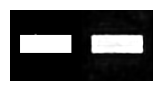

Epoch 19: 100%|█████████| 423/423 [01:16<00:00,  5.51it/s, recons_loss=0.043, gen_loss=0.652, disc_loss=0.167]


epoch 20 val loss: 0.0405


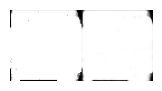

Epoch 29: 100%|████████| 423/423 [01:16<00:00,  5.52it/s, recons_loss=0.0367, gen_loss=0.572, disc_loss=0.166]


epoch 30 val loss: 0.0416


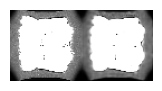

Epoch 39: 100%|████████| 423/423 [01:16<00:00,  5.50it/s, recons_loss=0.0342, gen_loss=0.527, disc_loss=0.178]


epoch 40 val loss: 0.0395


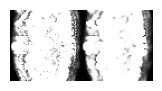

Epoch 49: 100%|████████| 423/423 [01:16<00:00,  5.50it/s, recons_loss=0.0306, gen_loss=0.489, disc_loss=0.189]


epoch 50 val loss: 0.0416


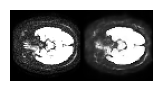

Epoch 59: 100%|█████████| 423/423 [01:17<00:00,  5.48it/s, recons_loss=0.029, gen_loss=0.449, disc_loss=0.196]


epoch 60 val loss: 0.0382


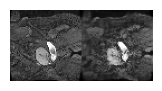

Epoch 69: 100%|████████| 423/423 [01:23<00:00,  5.05it/s, recons_loss=0.0277, gen_loss=0.423, disc_loss=0.206]


epoch 70 val loss: 0.0353


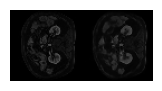

Epoch 74: 100%|████████| 423/423 [01:16<00:00,  5.51it/s, recons_loss=0.0264, gen_loss=0.404, disc_loss=0.206]


In [27]:
 # ## Train Autoencoder

# %%
kl_weight = 1e-6
n_epochs = 75
val_interval = 10
autoencoder_warm_up_n_epochs = 10

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            optimizer_d.zero_grad(set_to_none=True)

            with autocast(enabled=True):
                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                reconstruction, z_mu, z_sigma = autoencoderkl(images)
                recons_loss = F.l1_loss(images.float(), reconstruction.float())
                val_loss += recons_loss.item()

        val_loss /= val_step
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")

        # ploting reconstruction
        plt.figure(figsize=(2, 2))
        plt.imshow(torch.cat([images[0, 0].cpu(), reconstruction[0, 0].cpu()], dim=1), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

In [28]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.8627870678901672


In [29]:
# ## Train Diffusion Model
#
# In order to train the diffusion model to perform super-resolution, we will need to concatenate the latent representation of the high-resolution with the low-resolution image. For this, we create a Diffusion model with `in_channels=4`. Since only the outputted latent representation is interesting, we set `out_channels=3`.

# %%
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(256, 256, 512, 1024),
    attention_levels=(False, False, True, True),
    num_head_channels=(0, 0, 64, 64),
)
unet = unet.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)


In [30]:
# %%
low_res_scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

max_noise_level = 350

Epoch 19: 100%|█████████████████████████████████████████████████| 423/423 [01:39<00:00,  4.25it/s, loss=0.119]


Epoch 19 val loss: 0.1317


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.80it/s]


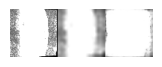

Epoch 20:   0%|▏                                                  | 2/423 [00:00<01:42,  4.13it/s, loss=0.145]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000, 121.0809],
        [  0.0000,  -0.6836,   0.0000, 254.9163],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
After SqueezeDim, img.affine is ill-posed: 
tensor([[  0.0000,   0.0000,   5.0000, -21.2000],
        [ -1.3281,   0.0000,   0.0000, 120.4360],
        [  0.0000,  -1.3281,   0.0000, 338.7360],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 20:   1%|▍                                                   | 4/423 [00:00<01:41,  4.13it/s, loss=0.12]After SqueezeDim, img.affine is ill-posed: 
tensor([[  -0.6836,    0.0000,    0.0000,  238.6207],
        [   0.0000,    0.0000,   -3.5000, -120.4191],
        [   0.0000,   -0.6836,    0.0000,  254.9163],
        [   0.0000,    0.0000,    0.0000

Epoch 39 val loss: 0.1133


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.90it/s]


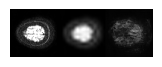

Epoch 40:   0%|▏                                                 | 2/423 [00:00<01:39,  4.23it/s, loss=0.0991]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000, -67.9191],
        [  0.0000,  -0.6836,   0.0000, 254.9163],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 40:   1%|▎                                                  | 3/423 [00:00<01:35,  4.39it/s, loss=0.182]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -1.3281,   0.0000,   0.0000, 138.1360],
        [  0.0000,   0.0000,  -5.0000, -43.9000],
        [  0.0000,  -1.3281,   0.0000, 338.7360],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 40:   2%|▉                                                  | 8/423 [00:01<01:35,  4.37it/s, loss=0.131]After SqueezeDim, img.affine is ill-posed: 
tensor([[  0.0000,   0.0000,   4.0000,  -1.2598],
        [ -0.5469,   0.0000,   0.0000, 105

Epoch 59 val loss: 0.1135


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.93it/s]


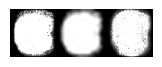

Epoch 60:   0%|                                                                       | 0/423 [00:00<?, ?it/s]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000, -36.4191],
        [  0.0000,  -0.6836,   0.0000, 254.9163],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 60:   0%|▏                                                 | 2/423 [00:00<01:42,  4.12it/s, loss=0.0423]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000,  12.5809],
        [  0.0000,  -0.6836,   0.0000, 254.9163],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 60:   1%|▌                                                 | 5/423 [00:01<01:40,  4.16it/s, loss=0.0793]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000, -81

Epoch 79 val loss: 0.1216


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.86it/s]


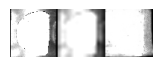

Epoch 80:   0%|                                                                       | 0/423 [00:00<?, ?it/s]After SqueezeDim, img.affine is ill-posed: 
tensor([[  0.0000,   0.0000,   6.0000, -36.0000],
        [ -0.7813,   0.0000,   0.0000, 141.5549],
        [  0.0000,  -0.7813,   0.0000,  87.9142],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 80:   0%|                                                  | 1/423 [00:00<01:29,  4.69it/s, loss=0.0291]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000, 135.0809],
        [  0.0000,  -0.6836,   0.0000, 254.9163],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 80:   1%|▎                                                 | 3/423 [00:00<01:38,  4.24it/s, loss=0.0697]After SqueezeDim, img.affine is ill-posed: 
tensor([[  0.0000,   0.0000,   6.0000,  30.0000],
        [ -0.9635,   0.0000,   0.0000, 125

Epoch 99 val loss: 0.0968


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.88it/s]


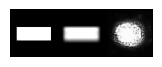

Epoch 100:   0%|                                                                      | 0/423 [00:00<?, ?it/s]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000, 110.5809],
        [  0.0000,  -0.6836,   0.0000, 254.9163],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 100:   0%|▏                                                 | 2/423 [00:00<01:36,  4.37it/s, loss=0.135]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000,  44.0809],
        [  0.0000,  -0.6836,   0.0000, 254.9163],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 100:   2%|▊                                                | 7/423 [00:01<01:40,  4.15it/s, loss=0.0861]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000, 138

Epoch 119 val loss: 0.1249


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.86it/s]


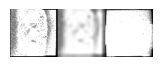

Epoch 120:   0%|▏                                                 | 2/423 [00:00<01:30,  4.63it/s, loss=0.126]After SqueezeDim, img.affine is ill-posed: 
tensor([[  0.0000,   0.0000,   6.0000, -36.0000],
        [ -0.7813,   0.0000,   0.0000, 141.5549],
        [  0.0000,  -0.7813,   0.0000,  87.9142],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 120:   1%|▌                                                 | 5/423 [00:01<01:36,  4.35it/s, loss=0.144]After SqueezeDim, img.affine is ill-posed: 
tensor([[  0.0000,   0.0000,   6.0000,  30.0000],
        [ -0.9635,   0.0000,   0.0000, 125.0000],
        [  0.0000,  -0.9635,   0.0000, 185.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 120:   1%|▋                                                 | 6/423 [00:01<01:35,  4.36it/s, loss=0.133]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000,  44

Epoch 139 val loss: 0.1208


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.88it/s]


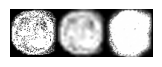

Epoch 140:   0%|                                                 | 1/423 [00:00<01:31,  4.59it/s, loss=0.0782]After SqueezeDim, img.affine is ill-posed: 
tensor([[-4.6211e-01,  0.0000e+00,  3.3675e+00,  2.0520e+02],
        [-7.8934e-02,  0.0000e+00, -1.9714e+01,  6.9647e+01],
        [ 0.0000e+00, -4.6880e-01,  0.0000e+00,  2.4901e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64).
After SqueezeDim, img.affine is ill-posed: 
tensor([[  0.0000,   0.0000,   6.0000,  24.0000],
        [ -0.9635,   0.0000,   0.0000, 125.0000],
        [  0.0000,  -0.9635,   0.0000, 185.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 140:   0%|▏                                                | 2/423 [00:00<01:39,  4.23it/s, loss=0.0503]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.4688,   0.0000,   0.0000, 207.2511],
        [  0.0000,   0.0000, -20.0000,  36.7777],
        [  0.0000,  -0.4688,   0.0000, 249.0111

Epoch 159 val loss: 0.1307


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.89it/s]


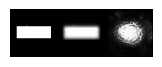

Epoch 160:   1%|▎                                                  | 3/423 [00:00<01:36,  4.34it/s, loss=0.07]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -1.5625,   0.0000,   0.0000, 188.0000],
        [  0.0000,   0.0000,  -6.0000, -99.6823],
        [  0.0000,  -1.5625,   0.0000,  82.4252],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 160:   1%|▍                                                | 4/423 [00:00<01:36,  4.33it/s, loss=0.0589]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.4688,   0.0000,   0.0000, 211.2101],
        [  0.0000,   0.0000, -30.0000,  40.8230],
        [  0.0000,  -0.4688,   0.0000, 149.6459],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 160:   1%|▌                                                | 5/423 [00:01<01:36,  4.33it/s, loss=0.0572]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000, 110

Epoch 179 val loss: 0.1362


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.92it/s]


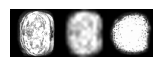

Epoch 180:   0%|                                                  | 1/423 [00:00<01:38,  4.28it/s, loss=0.152]After SqueezeDim, img.affine is ill-posed: 
tensor([[-4.4053e-01,  0.0000e+00,  1.0261e+01,  2.0286e+02],
        [-1.6034e-01,  0.0000e+00, -2.8191e+01,  9.1094e+01],
        [ 0.0000e+00, -4.6880e-01,  0.0000e+00,  1.4965e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64).
After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -3.5000,  44.0809],
        [  0.0000,  -0.6836,   0.0000, 254.9163],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
Epoch 180:   1%|▋                                                | 6/423 [00:01<01:37,  4.28it/s, loss=0.0947]After SqueezeDim, img.affine is ill-posed: 
tensor([[ -1.5625,   0.0000,   0.0000, 188.0000],
        [  0.0000,   0.0000,  -6.0000, -81.6823],
        [  0.0000,  -1.5625,   0.0000,  82.4252

Epoch 199 val loss: 0.1257


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.91it/s]


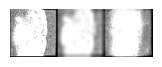

In [32]:
# %%
optimizer = torch.optim.Adam(unet.parameters(), lr=5e-5)

scaler_diffusion = GradScaler()

n_epochs = 200
val_interval = 20
epoch_loss_list = []
val_epoch_loss_list = []

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        low_res_image = batch["low_res_image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            with torch.no_grad():
                latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor

            # Noise augmentation
            noise = torch.randn_like(latent).to(device)
            low_res_noise = torch.randn_like(low_res_image).to(device)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device).long()
            low_res_timesteps = torch.randint(
                0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
            ).long()

            noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
            noisy_low_res_image = scheduler.add_noise(
                original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
            )

            latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)

            noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler_diffusion.scale(loss).backward()
        scaler_diffusion.step(optimizer)
        scaler_diffusion.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        for val_step, batch in enumerate(val_loader, start=1):
            images = batch["image"].to(device)
            low_res_image = batch["low_res_image"].to(device)

            with torch.no_grad():
                with autocast(enabled=True):
                    latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor
                    # Noise augmentation
                    noise = torch.randn_like(latent).to(device)
                    low_res_noise = torch.randn_like(low_res_image).to(device)
                    timesteps = torch.randint(
                        0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device
                    ).long()
                    low_res_timesteps = torch.randint(
                        0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
                    ).long()

                    noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
                    noisy_low_res_image = scheduler.add_noise(
                        original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
                    )

                    latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)
                    noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
                    loss = F.mse_loss(noise_pred.float(), noise.float())

            val_loss += loss.item()
        val_loss /= val_step
        val_epoch_loss_list.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        sampling_image = low_res_image[0].unsqueeze(0)
        latents = torch.randn((1, 3, 16, 16)).to(device)
        low_res_noise = torch.randn((1, 1, 16, 16)).to(device)
        noise_level = 20
        noise_level = torch.Tensor((noise_level,)).long().to(device)
        noisy_low_res_image = scheduler.add_noise(
            original_samples=sampling_image,
            noise=low_res_noise,
            timesteps=torch.Tensor((noise_level,)).long().to(device),
        )

        scheduler.set_timesteps(num_inference_steps=1000)
        for t in tqdm(scheduler.timesteps, ncols=110):
            with torch.no_grad():
                with autocast(enabled=True):
                    latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
                    noise_pred = unet(
                        x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level
                    )
                latents, _ = scheduler.step(noise_pred, t, latents)

        with torch.no_grad():
            decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

        low_res_bicubic = nn.functional.interpolate(sampling_image, (64, 64), mode="bicubic")
        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(
            torch.cat([images[0, 0].cpu(), low_res_bicubic[0, 0].cpu(), decoded[0, 0].cpu()], dim=1),
            vmin=0,
            vmax=1,
            cmap="gray",
        )
        plt.tight_layout()
        plt.axis("off")
        plt.show()

In [ ]:
print("noise_pred size:", low_res_noise.size())
print("noise size:", noise.size())

In [ ]:
print(noisy_latent.shape)
print(noisy_low_res_image.shape)
noisy_latent.shape[2:] != noisy_low_res_image.shape[2:]


In [ ]:
low_res_image.shape

After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.6836,   0.0000,   0.0000, 238.6207],
        [  0.0000,   0.0000,  -7.0000, -39.9191],
        [  0.0000,  -0.6836,   0.0000, 254.9163],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
After SqueezeDim, img.affine is ill-posed: 
tensor([[ -0.4688,   0.0000,   0.0000, 211.2794],
        [  0.0000,   0.0000,  -1.0000,  10.3652],
        [  0.0000,  -0.4688,   0.0000, 249.0111],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64).
100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.39it/s]


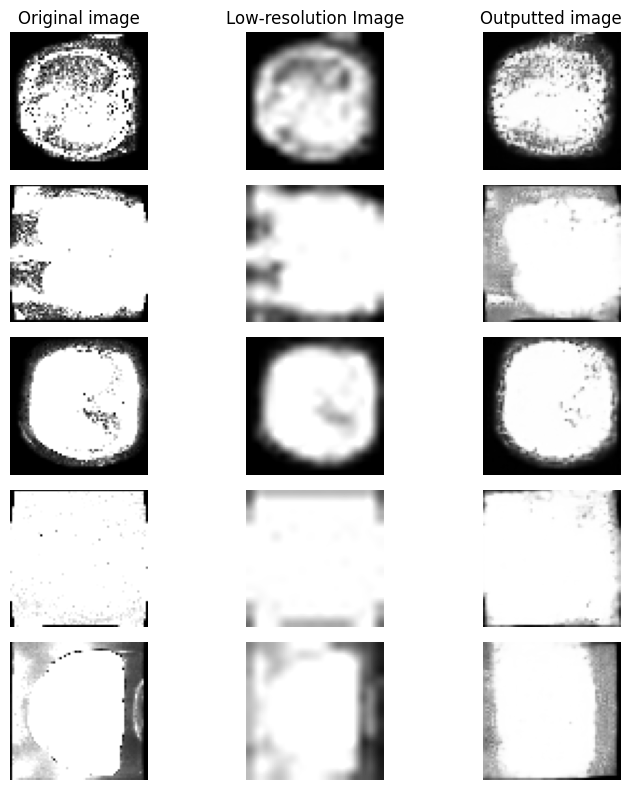

In [37]:
# ### Plotting sampling example

# %%
# Sampling image during training
unet.eval()
num_samples = 5
validation_batch = first(val_loader)

images = validation_batch["image"].to(device)
sampling_image = validation_batch["low_res_image"].to(device)[:num_samples]

# %%
latents = torch.randn((num_samples, 3, 16, 16)).to(device)
low_res_noise = torch.randn((num_samples, 1, 16, 16)).to(device)
noise_level = 10
noise_level = torch.Tensor((noise_level,)).long().to(device)
noisy_low_res_image = scheduler.add_noise(
    original_samples=sampling_image, noise=low_res_noise, timesteps=torch.Tensor((noise_level,)).long().to(device)
)
scheduler.set_timesteps(num_inference_steps=1000)
for t in tqdm(scheduler.timesteps, ncols=110):
    with torch.no_grad():
        with autocast(enabled=True):
            latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
            noise_pred = unet(x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level)

        # 2. compute previous image: x_t -> x_t-1
        latents, _ = scheduler.step(noise_pred, t, latents)

with torch.no_grad():
    decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

# %%
low_res_bicubic = nn.functional.interpolate(sampling_image, (64, 64), mode="bicubic")
fig, axs = plt.subplots(num_samples, 3, figsize=(8, 8))
axs[0, 0].set_title("Original image")
axs[0, 1].set_title("Low-resolution Image")
axs[0, 2].set_title("Outputted image")
for i in range(0, num_samples):
    axs[i, 0].imshow(images[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(low_res_bicubic[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 1].axis("off")
    axs[i, 2].imshow(decoded[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 2].axis("off")
plt.tight_layout()

In [ ]:
if directory is None:
  shutil.rmtree(root_dir)